# Exercise 5

Authors: Joseph Weibel, Rebecka Fahrni

In [169]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(50)


## Exercise 1a 
Loading data

In [170]:
# load datasets
data = np.load('data/data_all_button_press_window_events_hg.npy')

print('number of electrodes:  ', data.shape[1])
print('number of time samples:', data.shape[0])

number of electrodes:   199
number of time samples: 57


## Exercise 1b

Implement Fuzzy-C Means Clustering

In [171]:
def cluster(data, k):
	D = 3.5

	# 1st step: choose k random elctrodes as initial cluster centers
	centers = data[:, np.random.choice(data.shape[1], k, replace=False)]

	labels = None
	for iter in range(1000): # stop after 100 iterations to avoid infinite loops
		# 2nd step: update the cluster assignment
		dist = cdist(data.T, centers.T, 'sqeuclidean')
		new_labels = np.zeros((data.shape[1], k))
		for i in range(data.shape[1]):
			for j in range(k):
				new_labels[i, j] = 1 / (np.sum((dist[i, j] / (dist[i] + 1e-6)) ** (1 / (D - 1))) + 1e-6)

		# 3rd step: check for convergence
		if labels is not None and np.all(np.abs(new_labels - labels) < 1e-6):
			print(f'convergence after {iter+1} steps')
			break

		labels = new_labels

		# 4th step: update the cluster centers based on the new assignment
		centers = (data @ (labels ** D)) / np.sum(labels ** D, axis=0)

	# last step: calculate total squared distance
	dist = cdist(data.T, centers.T, 'sqeuclidean')
	total_squared_distance = (dist * (labels ** D)).sum()

	return total_squared_distance, labels.argmin(axis=1), centers


## Exercise 1c

Test different values for $k$

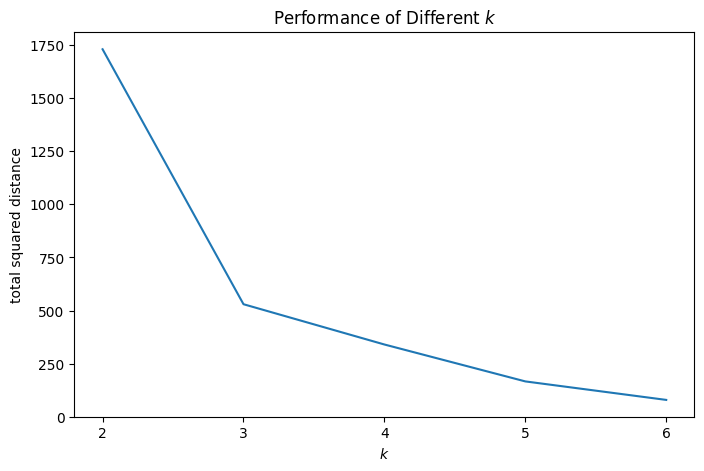

In [172]:
k_values = np.arange(2, 6 + 1)
distances = []
all_labels = []
all_centers = []

# try different k
for k in k_values:
	distance, labels, centers = cluster(data, k)
	distances.append(distance)
	all_labels.append(labels)
	all_centers.append(centers)

# plot distances
plt.figure(figsize=(8, 5))
plt.plot(k_values, distances)
plt.title('Performance of Different $k$')
plt.xlabel('$k$')
plt.ylabel('total squared distance')
plt.ylim(0)
plt.xticks(k_values)
plt.show()

We choose the optimal value for $k$ by plotting the total squared distance as a function of $k$. With increasing $k$ the total squared distance is decreasing which is expected as more centroids will decrease the average distance to one of those. By looking at this plot, we can apply the elbow test and find $k$ by looking for the bend in the curve. The elbow is not in every case visible. However in this case, $k = 3$ seems optimal as the decrease is only little with $k > 3$ compared to $k < 3$.

## Exercise 1d

visualize cluster results

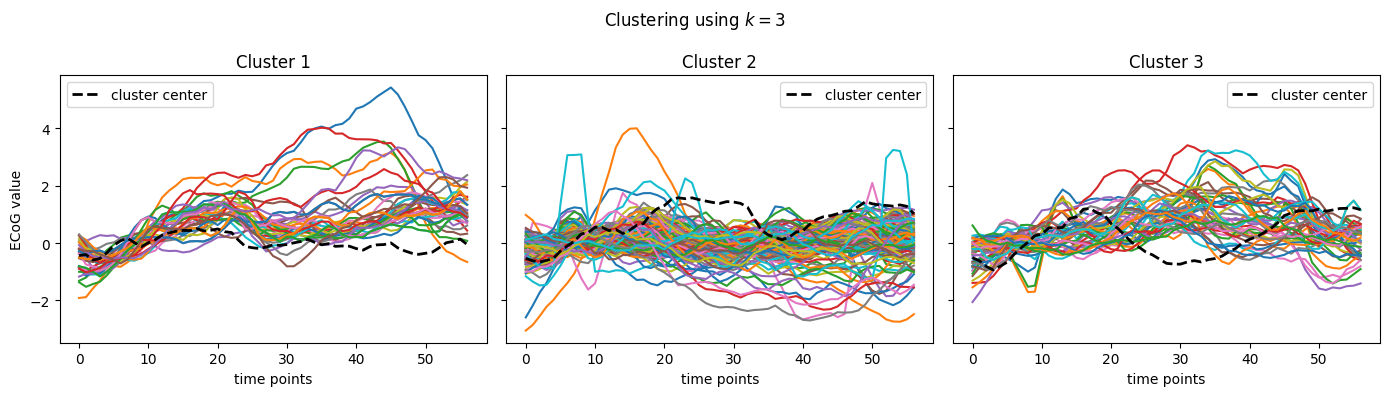

In [173]:
k = 3
index = np.where(k_values == k)[0][0]
labels = all_labels[index]
centers = all_centers[index]

fig, axes = plt.subplots(1, k, figsize=(k*4 + 2, 4), sharex=True, sharey=True)
for i in range(k):
	# plot data belonging to cluster
	axes[i].plot(data[:, labels == i])

	# plot cluster center
	# axes[i].plot(data[:, labels == i].mean(axis=1), linewidth=2, linestyle='--', c='black', label='cluster center')
	axes[i].plot(centers[:, i], linewidth=2, linestyle='--', c='black', label='cluster center')

	# add metadata
	axes[i].set_title(f'Cluster {i + 1}')
	axes[i].legend()
	axes[i].set_xlabel('time points')

# add figure metadata
axes[0].set_ylabel('ECoG value')
fig.suptitle(f'Clustering using $k = {k}$')
fig.tight_layout()
plt.show()